In [ ]:
import wave, os, glob
import noisereduce
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa.display
import sys
import numpy
import librosa
numpy.set_printoptions(threshold=sys.maxsize)
#from pydub import AudioSegment,silence
import math
from scipy.stats import variation 
import statistics
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# load all parameters file 
par_details = pd.read_csv(#'.../Stat_csv_files/AWNS_AWS_all_details.csv')# Change path as required


In [ ]:
par_details['All_events_durations'] = par_details['All_events_durations'].apply(lambda x: np.fromstring(x, sep=','))
par_details['long_p_durations'] = par_details['long_p_durations'].apply(lambda x: np.fromstring(x, sep=','))
par_details['short_p_durations'] = par_details['short_p_durations'].apply(lambda x: np.fromstring(x, sep=','))
par_details['Event_type'] = par_details['Event_type'].apply(lambda x: np.fromstring(x, sep=','))


In [ ]:
df_all_f_pre_nor = par_details[['All_events_durations','Event_type','Pause_Duration_s','Pause_Events','CV Speech','Mean Pause_s','long_p_count','Speech_Rate','short_p_durations_mean']]

In [ ]:
df_all_f_pre_nor_copy = df_all_f_pre_nor.copy()

In [ ]:
output_column = par_details['Group']
numerical_labels = np.array([0 if label == "AWS" else 1 for label in output_column])

In [ ]:
df_all_f_pre_nor_copy['Numerical_Label'] = numerical_labels

In [ ]:
scaler = StandardScaler()

In [ ]:
# Normalize all columns except 'All_events_durations', 'Event_type', and 'Numerical_Label'
columns_to_normalize = df_all_f_pre_nor_copy.columns.difference(['All_events_durations', 'Event_type', 'Numerical_Label'])
df_all_f_pre_nor_copy[columns_to_normalize] = scaler.fit_transform(df_all_f_pre_nor_copy[columns_to_normalize])


In [ ]:
# Define variables to store compiled data
input_data_2_segs = []
new_less = []
data_frames = []    # For 'Numerical_Label' == 1
data_frames_1 = []  # For 'Numerical_Label' == 0
data_frames_less = []

# Separate segments based on 'Numerical_Label' values
input_data_2_segs_1 = []  # For 'Numerical_Label' == 1
input_data_2_segs_2 = []  # For 'Numerical_Label' == 0

# Iterate over each row in df_all_f_pre_nor_copy to process event data
for idx, row in df_all_f_pre_nor_copy.iterrows():
    # Extract 'All_event_durations' as 'Time_diff' and 'Event_type' directly from the row
    input_data_2_seg = pd.DataFrame({'Time_diff': row['All_events_durations']})
    input_data_2_seg['Event_type'] = row['Event_type']
    
    # Normalize 'Time_diff' in the input segment
    input_data_2_seg['Time_diff'] = scaler.fit_transform(input_data_2_seg[['Time_diff']])
    
    #print(input_data_2_seg)
    # Repeat the other participant details for each event in the row
    row_df_use = row.drop(['All_events_durations', 'Event_type', 'Numerical_Label']).to_frame().T
    n = len(input_data_2_seg)
    df_repeated = pd.concat([row_df_use] * n, ignore_index=True, axis=0)
    
    # Concatenate event data with repeated participant details
    concatenated_df = pd.concat([input_data_2_seg, df_repeated], axis=1, ignore_index=False)
    
    # Append processed data to lists based on 'Numerical_Label' value
    input_data_2_segs.append(concatenated_df)
    new_less.append(input_data_2_seg)
    
    if row['Numerical_Label'] == 1:
        data_frames.append(concatenated_df)
        input_data_2_segs_1.append(concatenated_df)  # For input_data_2_1
    else:
        data_frames_1.append(concatenated_df)
        input_data_2_segs_2.append(concatenated_df)  # For input_data_2_2
        
    data_frames_less.append(input_data_2_seg)

# Compile all segments into separate DataFrames for output
input_data_2_1 = pd.concat(input_data_2_segs_1, axis=0, ignore_index=True)  # For 'Numerical_Label' == 1
input_data_2_2 = pd.concat(input_data_2_segs_2, axis=0, ignore_index=True)  # For 'Numerical_Label' == 0

# Generate label arrays for the compiled data lengths
input_data_2_1_label = np.full((len(input_data_2_1),), 1)
input_data_2_2_label = np.full((len(input_data_2_2),), 0)

# At this point:
# - input_data_2_1 contains compiled data for 'Numerical_Label' == 1. # AWNS
# - input_data_2_2 contains compiled data for 'Numerical_Label' == 0. # AWS
# - input_data_2_1_label and input_data_2_2_label provide labels for each set.
# - data_frames and data_frames_1 contain separated data 


In [ ]:
no_of_features = len(input_data_2_1.columns)
print(no_of_features)

9


In [ ]:
# Function to divide a DataFrame into segments of a 
# fixed length, ensuring all segments have the same number of rows

def segment_dataframe(df, sample_length):
    segments = []
    num_segments = len(df) // sample_length
    for i in range(num_segments):
        start = i * sample_length
        end = start + sample_length
        segments.append(df.iloc[start:end, :])
    if len(df) % sample_length != 0:
        # pad the last segment with zeros
        segment = df.iloc[end:, :]
        padding = pd.DataFrame(0, index=range(sample_length - len(segment)), columns=df.columns)
        segments.append(pd.concat([segment, padding]))
    return segments

In [ ]:
sample_length = 20
segments = []
for i in data_frames:
    dd = segment_dataframe(i, sample_length)
    #print(len(dd))
    segments.append(dd)
segments_1 = []
for i in data_frames_1:
    dd = segment_dataframe(i, sample_length)
    #print(len(dd))
    segments_1.append(dd)

In [ ]:
import random

# generate three different random numbers between 0 and len(data_frames)
num1_awns, num2_awns, num3_awns = random.sample(range(len(data_frames)), 3)

# ensure num2_awns is different from num1_awns
while num2_awns == num1_awns:
    num2_awns = random.randint(0, len(data_frames)-1)

# ensure num3_aws is different from both num1_awns and num2_awns
while num3_awns == num1_awns or num3_awns == num2_awns:
    num3_awns = random.randint(0, len(data_frames)-1)

print(num1_awns, num2_awns, num3_awns)

10 15 9


In [ ]:
# generate three different random numbers between 0 and len(data_frames_1)-1
num5_aws, num6_aws, num7_aws = random.sample(range(len(data_frames_1)), 3)

# ensure num6_aws is different from num5_aws
while num6_aws == num5_aws:
    num6_aws = random.randint(0, len(data_frames_1)-1)

# ensure num7_aws is different from num5_aws and num6_aws
num7_aws = random.randint(0, len(data_frames_1)-1)
while num7_aws == num5_aws or num7_aws == num6_aws:
    num7_aws = random.randint(0, len(data_frames_1)-1)

print(num5_aws, num6_aws, num7_aws)

9 16 11


In [ ]:
segments_all = [item for i, sublist in enumerate(segments) for item in sublist if i not in [num1_awns, num2_awns, num3_awns]]
#print(len(segments_all)) 
segments_all_1 = [item for i, sublist in enumerate(segments_1) for item in sublist if i not in [num5_aws, num6_aws, num7_aws]]
#print(len(segments_all_1))  

In [ ]:
# make test and validation sets
# put num1_awns and num3_aws together # test
segments_test = segments[num1_awns]+ segments[num2_awns]+segments_1[num5_aws]+segments_1[num6_aws]
#print(len(segments_test)) 
# put num2_awns and num4_aws together 
segments_val =  segments[num3_awns]+segments_1[num7_aws]
#print(len(segments_val))  

In [ ]:
combined_list_seg = segments_all+segments_all_1
#len(combined_list_seg)

In [ ]:
input_data_1_label = np.full((len(segments_all),), 0)
input_data_2_label = np.full((len(segments_all_1),), 1)

In [ ]:
y_train = np.concatenate((input_data_1_label,input_data_2_label), axis=0)
#y_train.shape

In [ ]:
# generate labels for test and validation sets 
# Test , len of awns = 0 is (num1_awns) and len of aws = 1 is (num3_aws)
y_test_1 = np.full((len(segments[num1_awns]),), 0)
y_test_2 = np.full((len(segments[num2_awns]),), 0)
y_test_3 = np.full((len(segments_1[num5_aws]),), 1)
y_test_4 = np.full((len(segments_1[num6_aws]),), 1)
y_test = np.concatenate((y_test_1,y_test_2,y_test_3,y_test_4), axis=0)
#print(y_test.shape)
# Val , len of awns = 0 is (num2_awns) and len of aws = 1 is (num4_aws)
y_val_1 = np.full((len(segments[num3_awns]),), 0)
y_val_2 = np.full((len(segments_1[num7_aws]),), 1)

y_val = np.concatenate((y_val_1,y_val_2), axis=0)
#print(y_val.shape)

In [ ]:
X_train= np.array(combined_list_seg).reshape((len(combined_list_seg), sample_length, no_of_features))

# print the shape of the resulting array
#print(X_train.shape)

In [ ]:
X_test= np.array(segments_test).reshape((len(segments_test), sample_length, no_of_features))

# print the shape of the resulting array
#print(X_test.shape)

In [ ]:
X_val= np.array(segments_val).reshape((len(segments_val), sample_length, no_of_features))

# print the shape of the resulting array
#print(X_val.shape)

In [ ]:
# Augment the training data set 

# create 3D array of shape (num_samples, height, width)
original_data = X_train

# create an empty array to store rotated data
rotated_data = np.empty_like(original_data)

# loop over each sample in the original data
for i in range(original_data.shape[0]):
    # rotate the sample by 180 degrees
    rotated_sample = np.rot90(original_data[i], k=2, axes=(0, 1))
    # store the rotated sample in the rotated data array
    rotated_data[i] = rotated_sample

# concatenate the original and rotated data along the sample axis
augmented_data = np.concatenate((original_data, rotated_data), axis=0)

# print the shape of the augmented data
print(augmented_data.shape)

(450, 20, 9)


In [ ]:
y_train_aug = np.concatenate((y_train,y_train), axis=0)
#y_train_aug.shape

In [ ]:
# Ensure data is a NumPy array of floats
augmented_data = np.array(augmented_data, dtype=np.float32)
y_train_aug = np.array(y_train_aug, dtype=np.float32)
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)

In [ ]:
# Make and run the LSTM model 
# Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

model = Sequential()
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None,no_of_features)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Initialize lists to store metrics (though these are used only for a single iteration now)
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Run model training and evaluation for a single iteration
print("Iteration 1:")

# Train the model (no validation data in this case)
history = model.fit(augmented_data, y_train_aug, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

# Predict using the test set
y_pred = model.predict(X_test)

# Round the predictions to the nearest integer (0 or 1)
y_pred = np.round(y_pred)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
accuracy = accuracy_score(y_test, y_pred)

# Append the results to the lists (even though we only have one iteration)
accuracies.append(accuracy)
f1_scores.append(f1_score)

# Print results for this single iteration
print('Accuracy:', accuracy)
print('F1-score:', f1_score)
print(num1_awns, num2_awns, num3_awns)
print(num5_aws, num6_aws, num7_aws)

In [ ]:
# Iteration 1:
# 2/2 [==============================] - 0s 5ms/step
# Accuracy: 0.6
# F1-score: 0.6666666666666666
# num1_awns, num2_awns, num3_awns - 3 11 9
# num5_aws, num6_aws, num7_aws - 1 12 9 


# Iteration 2:
# 1/1 [==============================] - 0s 254ms/step
# Accuracy: 0.7391304347826086
# F1-score: 0.625
# num1_awns, num2_awns, num3_awns - 13 2 8
# 15 2 8

# Iteration 3:
# 1/1 [==============================] - 0s 239ms/step
# Accuracy: 0.8
# F1-score: 0.7058823529411764
# num1_awns, num2_awns, num3_awns - 17 14 5
# 13 15 6

# Iteration 4:
# 1/1 [==============================] - 0s 216ms/step
# Accuracy: 0.8333333333333334
# F1-score: 0.8717948717948718
# 17 3 13
# 14 7 8

# Iteration 5:
# 1/1 [==============================] - 0s 192ms/step
# Accuracy: 0.7692307692307693
# F1-score: 0.7000000000000001
# 17 3 14
# 11 4 10

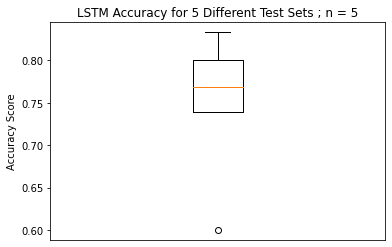

In [ ]:
# Plot the cross-validation scores
acc = [0.6,0.7391304347826086,0.8,0.8333333333333334,0.7692307692307693] # accuracy values - 
plt.boxplot(acc)
num =5
plt.title("LSTM Accuracy for 5 Different Test Sets ; n = %i" %num)
plt.xticks([])
plt.ylabel("Accuracy Score")
plt.show()

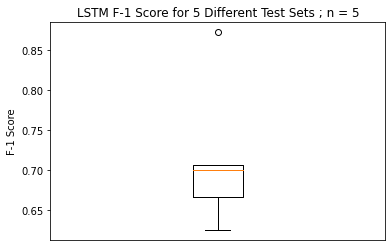

In [ ]:
# Plot the f-1 scores
f1 = [0.6666666666666666,0.625,0.7058823529411764,0.8717948717948718,0.7000000000000001] # f1 values - 
plt.boxplot(f1)
num =5
plt.title("LSTM F-1 Score for 5 Different Test Sets ; n = %i" %num)
plt.xticks([])
plt.ylabel("F-1 Score")
plt.show()